In [18]:
import os, yaml, sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
sys.path.append("../DeepGaze")
from scipy.ndimage import zoom
from scipy.special import logsumexp
import torch
import matplotlib.image as mpimg
sys.path.append("../DeepGaze")
import deepgaze_pytorch
import cv2

ENV = os.getenv("MY_ENV", "dev")
with open("../../config.yaml", "r") as f:
    config = yaml.safe_load(f)
paths = config[ENV]["paths"]
sys.path.append(paths["src_path"])
from image_processing.utils import read_video


In [ ]:
# if torch.cuda.is_available():
#     device = "cuda"
# elif torch.backends.mps.is_available():
#     device = "mps"
# else:
#     device = "cpu"
# # end if torch.cuda.is_available():

In [3]:
device = 'cpu'
v = read_video(paths, 1, "IMG_4704.mp4")

18:10:46 - rank 1 IMG_4704.mp4 read successfully


In [10]:
h, w = v.shape[1:3]

In [14]:
print(h,w)

1080 1920


In [15]:
round(h*.1)

108

In [32]:

input = v[0,:,:,:]

In [33]:


image = input.transpose(2,0,1)
image_tensor = torch.from_numpy(image).float().to(device)
image_tensor = image_tensor.unsqueeze(0)


In [34]:
model = deepgaze_pytorch.DeepGazeIIE(pretrained=True) # deepgaze_pytorch.DeepGazeIIE(pretrained=True)
model = model.to(torch.float32)  # convert weights
model = model.to(device)         # move to device

/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Loaded pretrained weights for efficientnet-b5


Using cache found in /Users/tizianocausin/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet201_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet201_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Using cache found in /Users/tizianocausin/.cache/torch/hub/pytorch_vision_v0.6.0
/Users/tizianocausin/Desktop/virtual_envs/temporal_context/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNeXt50_32X4D_Weights.IMAGENET1K_V1`. You can also use `weights=ResNeX

In [35]:
centerbias_template = np.load('../DeepGaze/centerbias_mit1003.npy') # downloaded at https://github.com/matthias-k/DeepGaze/releases/download/v1.0.0/centerbias_mit1003.npy
# rescale to match image size
centerbias = zoom(centerbias_template, (image_tensor.shape[2]/centerbias_template.shape[0], image_tensor.shape[3]/centerbias_template.shape[1]), order=0, mode='nearest')
# renormalize log density
print(centerbias.shape)
centerbias -= logsumexp(centerbias)
centerbias = torch.from_numpy(centerbias).float().to(device)
centerbias = centerbias.unsqueeze(0)

(1080, 1920)


In [36]:
with torch.no_grad():
    log_density_prediction = model(image_tensor, centerbias)

In [50]:
log_density_prediction.numpy().shape

(1, 1, 1080, 1920)

In [56]:
image.shape

(3, 1080, 1920)

In [61]:
log_ddensity_prediction = cv2.resize(log_density_prediction.numpy().squeeze(), (round(w*.2), round(h*.2)))
iimage = cv2.resize(image.transpose(1,2,0), (round(w*.2), round(h*.2)))

In [78]:
np.sum(np.exp(log_density_prediction.numpy()))
d = np.exp(log_ddensity_prediction)/np.sum(np.exp(log_ddensity_prediction))

In [80]:
np.sum(d)

0.99999994

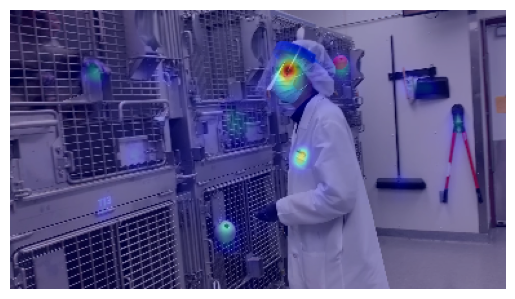

In [79]:
plt.imshow(iimage, alpha=1)             # background image
#plt.imshow(np.exp(log_ddensity_prediction.squeeze()), cmap='jet', alpha=0.4)  # semi-transparent heatmap overlay
plt.imshow(d, cmap='jet', alpha=0.4)  # semi-transparent heatmap overlay
plt.axis('off')
plt.show()

In [25]:
import tensorflow.compat.v1 as tf

tf.reset_default_graph()
tf.disable_v2_behavior()
check_point = '../deep_gaze/ICF.ckpt'  # DeepGaze II
new_saver = tf.train.import_meta_graph('{}.meta'.format(check_point))
input_tensor = tf.get_collection('input_tensor')[0]
centerbias_tensor = tf.get_collection('centerbias_tensor')[0]
log_density = tf.get_collection('log_density')[0]
log_density_wo_centerbias = tf.get_collection('log_density_wo_centerbias')[0]
# resize_tuple = (int(width*0.1),round(height*.1))
# dg_saliency_model=np.zeros((resize_tuple[1]*resize_tuple[0],frame_count)) #preallocation
# Read and display frames
# count=0
# while cap.isOpened():
#   ret, frame = cap.read()

#   image_data = frame[np.newaxis, :, :, :]  # BHWC, three channels (RGB), vectorizes the three channels

#     #tf.reset_default_graph()




Instructions for updating:
non-resource variables are not supported in the long term
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.


In [29]:
image_data = input

In [30]:
with tf.Session() as sess:
    new_saver.restore(sess, check_point)
    log_density_prediction_ICF = sess.run(log_density, {
    input_tensor: image_data[np.newaxis, :,:,:],
    centerbias_tensor: np.zeros((1,*image_data.shape[:2],1)),
    })

INFO:tensorflow:Restoring parameters from ../deep_gaze/ICF.ckpt


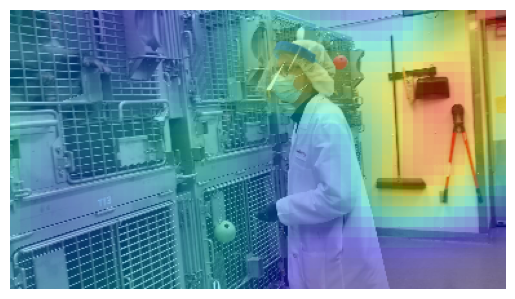

In [31]:
plt.imshow(image_data, alpha=1)             # background image
plt.imshow(np.exp(log_density_prediction_ICF.squeeze()), cmap='jet', alpha=.4)  # semi-transparent heatmap overlay
plt.axis('off')
plt.show()